In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import bootstrap, ttest_ind, ttest_rel
from scipy.stats import *
from statsmodels.stats import diagnostic
%matplotlib inline

# Homework 1 (HW1)

By the end of this homework, we expect you to be able to:

- Load data and handle data using pandas;
- Navigate the documentation of Python packages by yourself;
- Filter and tidy up noisy real-world datasets;
- Aggregate your data in different (and hopefully helpful) ways; 
- Create meaningful visualizations to analyze the data;

---

## Important Dates

- Homework release: Fri 14 Oct 2022
- **Homework due**: Sat 29 Oct 2022, 23:59
- Grade release: Mon 07 Nov 2022

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, 
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you 
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you 
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a 
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, 
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results 
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. 
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended,
 you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be 
**strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

In this homework, we will analyze data from A/B tests of headlines conducted by Upworthy from January 2013 to April 2015 to study whether the language used in the headline determines the number of people that will read the associated news piece. The homework contains four tasks: in task 1, we will process the data; in task 2, we will extract meaningful signals from the data; in task 3, we will test whether the language of headlines impacts their success; and in task 4, we will explore the heterogeneity of this effects (e.g., does it vary through time?).


### **What is an A/B test?** 
A/B tests are experiments that compare two scenarios (e.g., scenario A vs. scenario B). 
They test subjects' responses to each of the variants to determine which is more effective ([read more about A/B tests on Wikipedia](https://en.wikipedia.org/wiki/A/B_testing)). 
A/B tests allow us to draw conclusions about the different scenarios by randomizing exposure to them, e.g., one could flip a coin and assign a user to scenario A if it lands heads and to B if it lands tails. 
Since exposure is randomized, we can be confident that the scenarios are the sole explanation for statistically significant differences in subjects' responses (if they exist). 
In theory, A/B testing refers to an experiment that compares two scenarios; however, in practice, the term is also used when we compare multiple scenarios (e.g., A vs. B vs. C), although the more precise terminology would be to call such an experiment a "multinomial test."

### **How were A/B tests used by Upworthy?** 
Upworthy used A/B testing to increase news readership, conducting experiments for each published news piece. 
In each experiment, they created multiple "packages" of stimuli, varying headlines, images, excerpts, and ledes for the same news piece. 
Different "packages" were shown on their (now defunct) website to engage users with the news pieces they produced. Upworthy found "the best" package by conducting A/B tests, showing different packages to different users, and measuring how often users clicked on each version. 
Below, we show three "packages" used by Upworthy in an experiment, each with a different headline for the same news piece. 
Upworthy randomized users that visited their website saw one of the three versions of the headline below. Then, they measured the percentage of times users in each scenario clicked to read the news. 
The headline with the highest percentage of clicks per view (click through rate) was then declared the "winner" and became the default for all visitors.

![Example A/B test](example.png)

 ### **Where does this data come from?** 
 
 From a paper [1].

[1] Matias, J.N., Munger, K., Le Quere, M.A. et al. The Upworthy Research Archive, a time series of 32,487 experiments in U.S. media. Sci Data 8, 195 (2021). https://doi.org/10.1038/s41597-021-00934-7

### **Where can I find this data?**  

You can find it in the `/data/` folder.

### **Terminology**

- **News piece:** A news article. In the dataset considered, these were all produced by Upworthy.
- **Package:** The set of visual stimuli inviting the user to read an article. The figure above shows a package with a headline and an image. At times, there was an excerpt of the article also shown in the package and/or the lede, i.e., ["the introductory section of a news story that is intended to entice the reader to read the full story."](https://www.merriam-webster.com/words-at-play/bury-the-lede-versus-lead#:~:text=In%20journalism%2C%20the%20lede%20refers,machines%20began%20disappearing%20from%20newsrooms.)
- **Experiment:** Each experiment is an A/B test (or multinomial test, to be more precise) comparing how users reacted to different "packages." Experiments measured two things: 1) how many users were shown each package; and 2) how many individuals clicked each package.

### **Data description**

| Column name          | Description                                                                                                                                                                                       |   |   |   |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| created_at           | Time the package was created (timezone unknown)                                                                                                                                                   |   |   |   |
| test_week            | Week the package was created, a variable constructed by the archive creators for stratified random sampling                                                                                       |   |   |   |
| clickability_test_id | The test ID. Viewers were randomly assigned to packages with the same test ID                                                                                                                     |   |   |   |
| impressions          | The number of viewers who were assigned to this package. The total number of participants for a given test is the sum of impressions for all packages that share the same clickability_test_id    |   |   |   |
| headline             | The headline being tested                                                                                                                                                                         |   |   |   |
| eyecatcher_id        | Image ID. Image files are not available. Packages that shared the same image have the same eyecatcher_id                                                                                          |   |   |   |
| clicks               | The number of viewers (impressions) that clicked on the package. The clickrate for a given package is the number of clicks divided by the number of impressions                                   |   |   |   |
| excerpt              | Article excerpt                                                                                                                                                                                   |   |   |   |
| lede                 | The opening sentence or paragraph of the story                                                                                                                                                    |   |   |   |
| slug                 | Internal name for the web address                                                                                                                                                                 |   |   |   |
| share_text           | Summary for display on social media when the article is shared. This was not shown in tests, since tests were conducted on the Upworthy website                                                   |   |   |   |
| square               | When used, part of the same social media sharing suggestion as the share text                                                                                                                     |   |   |   |
| significance         | NOT an estimate of statistical significance; a complex, inconsistent calculation that compared the clicks on a package to the clicks on all previous packages that were fielded on the same pages |   |   |   |
| first_place          | Along with significance, shown to editors to guide decisions about what test to choose                                                                                                            |   |   |   |
| winner               | Whether a package was selected by editors to be used on the Upworthy site after the test                                                                                                          |   |   |   |
| updated_at           | The last time the package was updated in the Upworthy system                                                                                                                                      |   |   |   |


## Task 1: Getting familiar with the data

Your first task is to conduct initial analyses to understand the data and process it in a way that will allow us to more easily answer our key question: *how does the language of a headline determine its success?*

1.1 Load the data into memory using pandas and print the first lines to get a sense of it.

1.2 Each experiment comparing different versions of the same news piece ("packages") has a unique identifier (`clickability_test_id` column). 
Calculate how many different experiments were conducted in this dataset and, on average, how many packages were considered per experiment. 
Last, plot the distribution of packages per experiment with a visualization of your choice.

1.3 A common way to measure success in online A/B tests is what is called "the clickthrough rate."
Given that often A/B tests are created to find what engages users (here, "packages" of headlines, images, etc), we would expect that a "good" package makes people click often. 
Create a column named `ctr` by dividing the number of clicks a package received (`clicks` column) by the number of impressions it received (`impressions` column).

1.4 Packages varied any combination of the headline (`headline` column), the excerpt (`excerpt`), the first sentence of the article (`lede`), and the image that illustrates the news piece (`eyecatcher_id`, a hash per image). 
But we want to isolate the effect of the headline on the clickthrough rate. To do that, create a new dataframe where you filter all experiments where only one headline is present. 
Print the length of this new dataframe and how many experiments were discarded in the filtering process.

1.5 For comparison, repeat the procedure described in **T1.4** with the `eyecatcher_id` column, i.e., create a dataframe considering only experiments that vary the image. 
Again, print the length of this new dataframe and how many experiments were discarded in the filtering process.

1.6 **Discuss:** Considering the answers to questions **T1.4** and **T1.4**, what can we say about the different versions of the news tested by Upworthy?

1.7 For our subsequent analysis, we want to compare the causal effect of headlines on the success of a news piece. 
For that, we can compare pairs of packages with the same `eyecatcher_id`, `lede`, and `excerpt`, but different `headlines`.
Note that this means that if an experiment considered 5 different headlines and did not vary any other stimulus, we would have 5C2 (i.e., 5 choose 2, 10) pairs to consider.
Create a dataset where:
- each row corresponds to a pair of packages with different `headline` but the same `eyecatcher_id`, `lede`, and `excerpt`. 
- there are columns containing the headlines of each of the news versions (`headline1`, `headline2`) and the clickthrough rate of each of the news versions (`ctr1`, `ctr2`). 
- the columns `headline1` and `ctr1` contain the data associated with the news version with the highest clickthrough rate. Print the first columns of your newly created dataframe, as well as its length.
-  the columns where the two news pieces had exactly the same clickthrough rate should be filtered out (this is for simplicity's sake).
-  the column `date_created` contains the date when the news version with the highest clickthrough rate was created.

1.8 To get a sense of the impact of headline change, measure the average difference per pair between the most clicked-through (`ctr1`) and the least clicked-through headline (`ctr2`), as well as the average clickthrough rate for the least clicked through headline (`ctr2`). 

1.9 **Discuss:** Considering your answer to **T1.8**, and assuming the average differences in clickthrough rates between pairs are statistically significant, do you think that headlines are impactful in the news business? Justify with the data.

1.1 Load the data into memory using pandas and print the first lines to get a sense of it.

In [27]:
pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 20

data_folder = "./Data/"

packages = pd.read_csv(
    data_folder + "upworthy.csv.gz",
    parse_dates=["created_at", "updated_at"],
    na_values=["Nan"],
)
packages.head()

,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week
0,2014-11-20 06:43:16.005,2016-04-02 16:33:38.062,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3052,150,100.0,True,True,Anyone who's ever felt guilty about shopping a...,NaN,201446
1,2014-11-20 06:54:36.335,2016-04-02 16:25:54.027,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546bc55335992b86c8000043,3526,90,4.1,False,False,"If you ever wondered, ""but what about the men?...",NaN,201446
2,2014-11-20 06:54:57.878,2016-04-02 16:31:45.671,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546d900426714cd2dd00002e,3506,120,100.0,True,False,"If you ever wondered, ""but what about the men?...",NaN,201446
3,2014-11-20 06:55:07.212,2016-04-02 16:25:54.029,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546d900426714c6c44000038,3380,98,25.3,False,False,"If you ever wondered, ""but what about the men?...",NaN,201446
4,2014-11-20 06:55:20.347,2016-04-02 16:25:54.032,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546d900426714c1ad900001e,3465,75,0.2,False,False,"If you ever wondered, ""but what about the men?...",NaN,201446


1.2 Each experiment comparing different versions of the same news piece ("packages") has a unique identifier (clickability_test_id column). Calculate how many different experiments were conducted in this dataset and, on average, how many packages were considered per experiment. Last, plot the distribution of packages per experiment with a visualization of your choice.



The total number of experiments is 4822 with on averange 4.27 packages considered per experiment and a standar deviation of 1.4 packages 


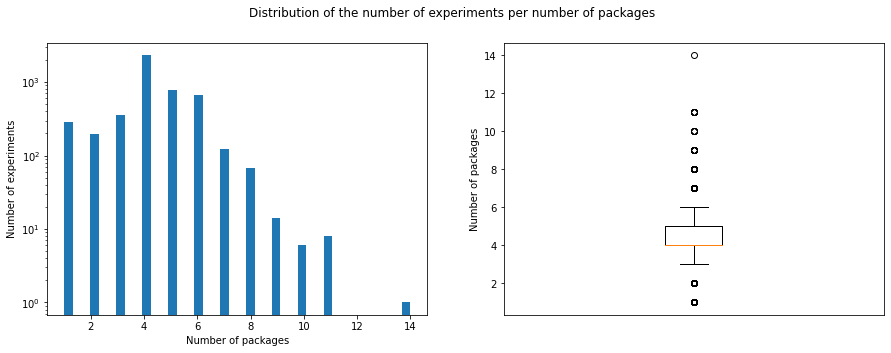

In [28]:
experiment_by_id = packages.groupby("clickability_test_id")
count_by_experiment = packages.groupby("clickability_test_id").count()["created_at"]

nb_experiment = count_by_experiment.count()
mean_nb_experiment = count_by_experiment.mean()
std_nb_experiment = count_by_experiment.std()
print(
    "The total number of experiments is %d with on averange %0.2f packages considered per experiment and a standar deviation of %0.1f packages "
    % (nb_experiment, mean_nb_experiment, std_nb_experiment)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Distribution of the number of experiments per number of packages")
ax1.hist(count_by_experiment.values, bins=40)

ax1.set(xlabel="Number of packages", ylabel="Number of experiments", yscale="log")
ax2.boxplot(count_by_experiment)
ax2 = ax2.set(xticks=[], ylabel="Number of packages")

1.3 A common way to measure success in online A/B tests is what is called "the clickthrough rate." Given that often A/B tests are created to find what engages users (here, "packages" of headlines, images, etc), we would expect that a "good" package makes people click often. Create a column named ctr by dividing the number of clicks a package received (clicks column) by the number of impressions it received (impressions column).

In [29]:
packages["ctr"] = packages.apply(lambda row: row["clicks"] / row["impressions"], axis=1)
packages.sort_values(by="ctr", ascending=False).head()

,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week,ctr
7310,2013-07-08 21:20:09.751,2016-04-02 16:27:08.742,51db2af3b96d816dea00825f,A famous actor makes a frightening discovery a...,Dustin Hoffman Breaks Down Trying To Explain S...,"<p>Back in the day, for those of you younger f...",dustin-hoffman-breaks-down-trying-to-explain-s...,5332bcd71fae79f09f00746c,1661,226,0.0,False,False,NaN,hoffman9.jpg,201327,0.136063
7545,2013-07-18 19:57:18.439,2016-04-02 16:27:13.724,51e8482dd0637d55cf000a49,"The Daily Show rarely get this mad, but when t...",It's Rare That The Daily Show Slips Out Of Sat...,<p>\n\t Leave it to the The Dai...,its-rare-that-the-daily-show-slips-out-of-sati...,5332bd531fae79f09f007fb0,2252,300,100.0,True,False,NaN,oliver4.jpg,201328,0.133215
7307,2013-07-08 21:18:24.892,2016-04-02 16:27:08.734,51db2af3b96d816dea00825f,A famous actor makes a frightening discovery a...,Dustin Hoffman Breaks Down Crying Trying To Ex...,"<p>Back in the day, for those of you younger f...",dustin-hoffman-breaks-down-crying-trying-to-ex...,5332bcd71fae79f09f00746c,1536,196,0.0,False,False,NaN,hoffman9.jpg,201327,0.127604
7542,2013-07-18 19:56:33.946,2016-04-02 16:27:13.717,51e8482dd0637d55cf000a49,"The Daily Show rarely get this mad, but when t...",It's Rare That The Daily Show Slips Out Of Sat...,<p>\n\t Leave it to the The Da...,its-rare-that-the-daily-show-slips-out-of-sati...,5332bd531fae79f09f007fad,2200,279,79.2,False,False,NaN,oliver2.jpg,201328,0.126818
16575,2014-09-17 20:55:13.084,2016-04-02 16:30:41.428,5419ed6f3088cfcf1f0000c0,Things that matter. Pass 'em on.,A Teen Comes Out To His Mom But His Mom Actual...,<p>Coming out can be pretty scary for lots of ...,a-teen-comes-out-to-his-mom-but-his-mom-actual...,5418e71f3088cf5bfc000023,6602,811,100.0,True,False,NaN,NaN,201437,0.122842


1.4 Packages varied any combination of the headline (headline column), the excerpt (excerpt), the first sentence of the article (lede), and the image that illustrates the news piece (eyecatcher_id, a hash per image). But we want to isolate the effect of the headline on the clickthrough rate. To do that, create a new dataframe where you filter all experiments where only one headline is present. Print the length of this new dataframe and how many experiments were discarded in the filtering process.

In [30]:
### Packages where there is more than one headline
# not_unique_headline_df = packages.groupby(by=['clickability_test_id']).filter(lambda x : len(x.groupby('headline'))!=1)
not_unique_headline_df = packages.groupby(by=["clickability_test_id"]).filter(
    lambda x: x["headline"].nunique() != 1
)

### Number of expermient where there is more than one headline
not_unique_headline_exp_count = (
    not_unique_headline_df.groupby("clickability_test_id").count()["created_at"].count()
)
print(
    "The new dataframe length is %d.\n%d expermients were retained and %d experiments were dropped "
    % (
        len(not_unique_headline_df),
        not_unique_headline_exp_count,
        nb_experiment - not_unique_headline_exp_count,
    )
)

The new dataframe length is 11600.
2586 expermients were retained and 2236 experiments were dropped 


1.5 For comparison, repeat the procedure described in T1.4 with the eyecatcher_id column, i.e., create a dataframe considering only experiments that vary the image. Again, print the length of this new dataframe and how many experiments were discarded in the filtering process.

In [31]:
### Packages where there is more than one image
# not_unique_image_df = packages.groupby(by=['clickability_test_id']).filter(lambda x : len(x.groupby('eyecatcher_id'))!=1)
not_unique_image_df = packages.groupby(by=["clickability_test_id"]).filter(
    lambda x: x["eyecatcher_id"].nunique() != 1
)

### Number of expermient where there is more than one image
not_unique_image_exp_count = (
    not_unique_image_df.groupby("clickability_test_id").count()["created_at"].count()
)
print(
    "The new dataframe length is %d.\n%d expermients were retained and %d experiments were dropped "
    % (
        len(not_unique_image_df),
        not_unique_image_exp_count,
        nb_experiment - not_unique_image_exp_count,
    )
)

The new dataframe length is 7948.
1719 expermients were retained and 3103 experiments were dropped 


1.6 **Discuss:** Considering the answers to questions **T1.4** and **T1.4**, what can we say about the different versions of the news tested by Upworthy?

We can see that the experiment concidered more variations on the headlines than the eye catchers since more than half experiments do vary the headlines (2586) whereas less than half experiments vary the eyecatchers (1719)

1.7 For our subsequent analysis, we want to compare the causal effect of headlines on the success of a news piece. 
For that, we can compare pairs of packages with the same `eyecatcher_id`, `lede`, and `excerpt`, but different `headlines`.
Note that this means that if an experiment considered 5 different headlines and did not vary any other stimulus, we would have 5C2 (i.e., 5 choose 2, 10) pairs to consider.
Create a dataset where:
- each row corresponds to a pair of packages with different `headline` but the same `eyecatcher_id`, `lede`, and `excerpt`. 
- there are columns containing the headlines of each of the news versions (`headline1`, `headline2`) and the clickthrough rate of each of the news versions (`ctr1`, `ctr2`). 
- the columns `headline1` and `ctr1` contain the data associated with the news version with the highest clickthrough rate. Print the first columns of your newly created dataframe, as well as its length.
-  the columns where the two news pieces had exactly the same clickthrough rate should be filtered out (this is for simplicity's sake).
-  the column `date_created` contains the date when the news version with the highest clickthrough rate was created.


In [32]:
comparaison = not_unique_headline_df.merge(
    not_unique_headline_df,
    on=["clickability_test_id", "eyecatcher_id", "lede", "excerpt"],
    how="inner",
)


### Filtering out rows where clickthrough rate is identical
comparaison = comparaison.drop(
    comparaison[comparaison["ctr_x"] == comparaison["ctr_y"]].index
)

### New dataframe
comparaison_final = pd.DataFrame()
### Retreiving ids for identification
# comparaison_final['clickability_test_id']= comparaison['clickability_test_id']
### Selecting headline1, headline2 , ctr1, ctr2, date_created based on ctr_comapraison criteria

comparaison_final["headline1"] = comparaison.apply(
    lambda row: row["headline_x"] if row["ctr_x"] > row["ctr_y"] else row["headline_y"],
    axis=1,
)
comparaison_final["headline2"] = comparaison.apply(
    lambda row: row["headline_x"] if row["ctr_x"] < row["ctr_y"] else row["headline_y"],
    axis=1,
)
comparaison_final["ctr1"] = comparaison.apply(
    lambda row: row["ctr_x"] if row["ctr_x"] > row["ctr_y"] else row["ctr_y"], axis=1
)
comparaison_final["ctr2"] = comparaison.apply(
    lambda row: row["ctr_x"] if row["ctr_x"] < row["ctr_y"] else row["ctr_y"], axis=1
)
comparaison_final["date_created"] = comparaison.apply(
    lambda row: row["created_at_x"]
    if row["ctr_x"] > row["ctr_y"]
    else row["created_at_y"],
    axis=1,
)
comparaison_final["eyecatcher_id"] = comparaison["eyecatcher_id"]
comparaison_final["lede"] = comparaison["lede"]
comparaison_final["excerpt"] = comparaison["excerpt"]

### Dropping duplicates
comparaison_final = comparaison_final.drop_duplicates()
print("The DataSetLength is equal to %d " % len(comparaison_final))
comparaison_final

The DataSetLength is equal to 17727 


,headline1,headline2,ctr1,ctr2,date_created,eyecatcher_id,lede,excerpt
1,A Science Guy Helps 3 Dudes From America Under...,What They Learned From The Scientist Was Terri...,0.012689,0.011101,2014-11-20 14:54:18.780,546c7f2dbadeb5788700000a,<p>Some decent guys fighting for an important ...,Things that matter. Pass 'em on.
2,What They Learned From The Scientist Was Terri...,He Sat Them Down And Told Them About An Immine...,0.011101,0.005868,2014-11-20 14:57:52.478,546c7f2dbadeb5788700000a,<p>Some decent guys fighting for an important ...,Things that matter. Pass 'em on.
3,"The 3 Of Them Needed To See It In Person, And ...",What They Learned From The Scientist Was Terri...,0.013795,0.011101,2014-11-20 15:13:36.266,546c7f2dbadeb5788700000a,<p>Some decent guys fighting for an important ...,Things that matter. Pass 'em on.
4,What They Learned From The Scientist Was Terri...,"They May Not Be The Most Handsome Dudes, But T...",0.011101,0.009726,2014-11-20 14:57:52.478,546c7f2dbadeb5788700000a,<p>Some decent guys fighting for an important ...,Things that matter. Pass 'em on.
5,He Showed Them Some Slides That Freaked Them O...,What They Learned From The Scientist Was Terri...,0.011568,0.011101,2014-11-20 15:09:47.669,546c7f2dbadeb5788700000a,<p>Some decent guys fighting for an important ...,Things that matter. Pass 'em on.
...,...,...,...,...,...,...,...,...
47044,Ferguson Has Taught Us Many Things. Here's The...,"When We Were Young, We Were Taught That Cops W...",0.007845,0.004948,2014-11-19 22:08:22.857,546c567f545240b352000009,<p>Sad but true: It took the deaths of several...,Things that matter. Pass 'em on.
47045,"A Pen, Paper, And Watercolors Tell One Of The ...","When We Were Young, We Were Taught That Cops W...",0.010920,0.004948,2014-11-19 22:08:27.941,546c567f545240b352000009,<p>Sad but true: It took the deaths of several...,Things that matter. Pass 'em on.
47048,An Artist Animates The Ugly Truth We Should Al...,Ferguson Has Taught Us Many Things. Here's The...,0.009219,0.007845,2014-11-19 22:08:18.431,546c567f545240b352000009,<p>Sad but true: It took the deaths of several...,Things that matter. Pass 'em on.
47049,"A Pen, Paper, And Watercolors Tell One Of The ...",An Artist Animates The Ugly Truth We Should Al...,0.010920,0.009219,2014-11-19 22:08:27.941,546c567f545240b352000009,<p>Sad but true: It took the deaths of several...,Things that matter. Pass 'em on.


1.8 To get a sense of the impact of headline change, measure the average difference per pair between the most clicked-through (`ctr1`) and the least clicked-through headline (`ctr2`), as well as the average clickthrough rate for the least clicked through headline (`ctr2`). 

In [33]:
comparaison_final["delta_ctr"] = comparaison_final.apply(
    lambda row: row["ctr1"] - row["ctr2"], axis=1
)

print(
    "The average difference per pair between the most clicked-through and the least clicked-through headline is "
    + "{:.2%}".format(comparaison_final["delta_ctr"].mean())
    + " and has a standard deviation of "
    "{:.2%}".format(comparaison_final["delta_ctr"].std())
)
print(
    "The average clickthrough rate for the least clicked through headline is "
    + "{:.2%}".format(comparaison_final["ctr2"].mean())
    + " and has a standard deviation of "
    "{:.2%}".format(comparaison_final["ctr2"].std())
)

The average difference per pair between the most clicked-through and the least clicked-through headline is 0.41% and has a standard deviation of 0.46%
The average clickthrough rate for the least clicked through headline is 1.07% and has a standard deviation of 0.95%


1.9 **Discuss:** Considering your answer to **T1.8**, and assuming the average differences in clickthrough rates between pairs are statistically significant, do you think that headlines are impactful in the news business? Justify with the data.

Since the results are considered statistically significant, we can asseert that the average difference per pair between the most clicked-through and the least clicked-through headline is 0.4%. 

At the first sight, these differences do not seem to be consequent.

However, when we mitigate them by the fact that the average clickthrough rate for the least clicked through headline is 1% we can infer that, only by choosing a better headline, the clickthrough rate increases by 40%.

Thus, headlines are a key element in the news business.

## Task 2: Extracting signals from the data

Your second task is to extract meaningful signals from the data. 
We start this task from the dataset obtained in **T1.7**. 
Recall that we have one A/B test per row with the clickthrough rate of two news pieces that differ only in their headline. 
We refer to the version with the higher clickthrough rate as the "winner" and the version with the lower as the "loser." 
(Note that this is not the same as the column `winner` in the original data, which captures a similar concept but considering the original experiments, where multiple comparisons were made!)
 
2.1 Using the function provided below, count the number of words in each headline, creating columns `numwords1` and `numwords2` corresponding to the number of words in the winner and loser headlines.

2.2 Using the dictionary of pronouns provided below, create indicator variables corresponding to each set of pronouns (e.g., first-person singular may yield columns `first_person_singular1` and `first_person_singular2` for the headlines in each A/B test). 
Each indicator variable in the dataframe should equal 1 if the corresponding headline uses the corresponding type of pronoun and 0 otherwise. 
Your code should be agnostic to lower/upper case.

2.3 One easy way to classify sentiment is simply to match negative or positive words. 
Use the linked lists of words ([positive][1], [negative][2]) to obtain "positive sentiment" and "negative sentiment" scores for each headline. Create columns `positive1`/`positive2` and `negative1`/`negative2` containing indicator variables for positive and negative sentiment, i.e., A headline has a "positive sentiment" (or negative) score equal 1 if it contains at least one positive (or negative) sentiment word on the list. Otherwise, its "positive sentiment" (or negative) score equals 0.
    
[1]: https://ptrckprry.com/course/ssd/data/positive-words.txt
[2]: https://ptrckprry.com/course/ssd/data/negative-words.txt

--- 

**Comments**

- For **T2.3**, beware of encodings!

2.1 Using the function provided below, count the number of words in each headline, creating columns `numwords1` and `numwords2` corresponding to the number of words in the winner and loser headlines.

In [34]:
# 2.1 (provided code)
def count_words_simple(x):
    return len(x.split(" "))


str_test = "How many words are here?"
print(str_test, count_words_simple(str_test))

How many words are here? 5


In [35]:
comparaison_final["numwords1"] = comparaison_final.apply(
    lambda row: count_words_simple(row["headline1"]), axis=1
)
comparaison_final["numwords2"] = comparaison_final.apply(
    lambda row: count_words_simple(row["headline2"]), axis=1
)
comparaison_final.sort_values(
    by=["numwords1", "numwords1"], ascending=[False, False]
).head()

,headline1,headline2,ctr1,ctr2,date_created,eyecatcher_id,lede,excerpt,delta_ctr,numwords1,numwords2
34637,In A Little While Its Going To Take Much Longe...,If I Told You What This Is About You Almost De...,0.006942,0.006406,2014-06-20 19:25:17.790,53a4622e62e6f5695c00009b,<p>Here at the Upworthy Conglomerated Offices ...,Things that matter. Pass 'em on.,0.000536,24,16
34642,In A Little While Its Going To Take Much Longe...,The American People Are Simply Allowing This I...,0.006942,0.002950,2014-06-20 19:25:17.790,53a4622e62e6f5695c00009b,<p>Here at the Upworthy Conglomerated Offices ...,Things that matter. Pass 'em on.,0.003992,24,17
34647,In A Little While Its Going To Take Much Longe...,No Matter How Many People You Have In Your Car...,0.006942,0.005790,2014-06-20 19:25:17.790,53a4622e62e6f5695c00009b,<p>Here at the Upworthy Conglomerated Offices ...,Things that matter. Pass 'em on.,0.001153,24,19
34652,In A Little While Its Going To Take Much Longe...,The Corrupt Insanity That You Seem To Want To ...,0.006942,0.005945,2014-06-20 19:25:17.790,53a4622e62e6f5695c00009b,<p>Here at the Upworthy Conglomerated Offices ...,Things that matter. Pass 'em on.,0.000998,24,12
1933,She Started A Diary To Help Her Understand Why...,A Wrestler Is Helping People See That Anyone C...,0.021238,0.007177,2015-01-28 23:30:25.542,54c872e131303300250c0000,<p>He makes me proud to call myself a feminist...,NaN,0.014061,23,12


2.2 Using the dictionary of pronouns provided below, create indicator variables corresponding to each set of pronouns (e.g., first-person singular may yield columns `first_person_singular1` and `first_person_singular2` for the headlines in each A/B test). 
Each indicator variable in the dataframe should equal 1 if the corresponding headline uses the corresponding type of pronoun and 0 otherwise. 
Your code should be agnostic to lower/upper case.


In [36]:
# 2.2 (provided code)
feature_wordsets = dict(
    [
        # https://en.wikipedia.org/wiki/English_personal_pronouns
        (
            "first_person_singular",
            [
                "i",
                "me",
                "my",
                "mine",
                "myself",
                "i'd",
                "i'll",
                "i'm",
                "i've",
                "id",
                "im",
                "ive",
            ],
        ),
        (
            "first_person_plural",
            [
                "we",
                "us",
                "our",
                "ours",
                "ourselves",
                "we'd",
                "we'll",
                "we're",
                "we've",
            ],
        ),
        (
            "second_person",
            [
                "you",
                "your",
                "yours",
                "yourself",
                "ya",
                "you'd",
                "you'll",
                "you're",
                "you've",
                "youll",
                "youre",
                "youve",
                "yourselves",
            ],
        ),
        (
            "third_person_singular",
            [
                "he",
                "him",
                "his",
                "himself",
                "he'd",
                "he's",
                "hes",
                "she",
                "her",
                "hers",
                "herself",
                "she'll",
                "she's",
                "shes",
                "it",
                "its",
                "itself",
                "themself",
            ],
        ),
        (
            "third_person_plural",
            [
                "they",
                "them",
                "their",
                "theirs",
                "themselves",
                "they'd",
                "they'll",
                "they've",
                "theyll",
                "theyve",
            ],
        ),
    ]
)

In [37]:
for i in range(1, 3):
    for key in feature_wordsets:
        comparaison_final[key + str(i)] = comparaison_final.apply(
            lambda row: 0
            if len(
                set(row["headline" + str(i)].lower().split(" "))
                & set(feature_wordsets[key])
            )
            == 0
            else 1,
            axis=1,
        )

In [38]:
comparaison_final.sort_values(by=["ctr1", "ctr2"], ascending=[False, False]).head()

,headline1,headline2,ctr1,ctr2,date_created,eyecatcher_id,lede,excerpt,delta_ctr,numwords1,numwords2,first_person_singular1,first_person_plural1,second_person1,third_person_singular1,third_person_plural1,first_person_singular2,first_person_plural2,second_person2,third_person_singular2,third_person_plural2
24738,Dustin Hoffman Breaks Down Trying To Explain S...,Dustin Hoffman Breaks Down Crying Trying To Ex...,0.136063,0.127604,2013-07-08 21:20:09.751,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.008458,14,15,0,0,0,0,0,0,0,0,0,0
24746,Dustin Hoffman Breaks Down Trying To Explain S...,Dustin Hoffman Loses It Trying To Explain Some...,0.136063,0.121882,2013-07-08 21:20:09.751,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.014181,14,14,0,0,0,0,0,0,0,0,1,0
24742,Dustin Hoffman Breaks Down Trying To Explain S...,Dustin Hoffman Loses It Trying To Explain Some...,0.136063,0.113088,2013-07-08 21:20:09.751,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.022974,14,14,0,0,0,0,0,0,0,0,1,0
24737,Dustin Hoffman Breaks Down Crying Trying To Ex...,Dustin Hoffman Loses It Trying To Explain Some...,0.127604,0.121882,2013-07-08 21:18:24.892,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.005722,15,14,0,0,0,0,0,0,0,0,1,0
24736,Dustin Hoffman Breaks Down Crying Trying To Ex...,Dustin Hoffman Loses It Trying To Explain Some...,0.127604,0.113088,2013-07-08 21:18:24.892,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.014516,15,14,0,0,0,0,0,0,0,0,1,0


2.3 One easy way to classify sentiment is simply to match negative or positive words. 
Use the linked lists of words ([positive][1], [negative][2]) to obtain "positive sentiment" and "negative sentiment" scores for each headline. Create columns `positive1`/`positive2` and `negative1`/`negative2` containing indicator variables for positive and negative sentiment, i.e., A headline has a "positive sentiment" (or negative) score equal 1 if it contains at least one positive (or negative) sentiment word on the list. Otherwise, its "positive sentiment" (or negative) score equals 0.
    
[1]: https://ptrckprry.com/course/ssd/data/positive-words.txt
[2]: https://ptrckprry.com/course/ssd/data/negative-words.txt


In [39]:
# read positive words file
with open(data_folder + "positive-words.txt", encoding="ISO-8859-1") as p:
    pos = p.readlines()[35:]

pos = [s.strip() for s in pos]

# read negative words file
with open(data_folder + "negative-words.txt", encoding="ISO-8859-1") as n:
    neg = n.readlines()[35:]

neg = [s.strip() for s in neg]

In [40]:
comparaison_final["positive1"] = comparaison_final.apply(
    lambda row: 0
    if len(set(row["headline1"].lower().split(" ")) & set(pos)) == 0
    else 1,
    axis=1,
)
comparaison_final["positive2"] = comparaison_final.apply(
    lambda row: 0
    if len(set(row["headline2"].lower().split(" ")) & set(pos)) == 0
    else 1,
    axis=1,
)
comparaison_final["negative1"] = comparaison_final.apply(
    lambda row: 0
    if len(set(row["headline1"].lower().split(" ")) & set(neg)) == 0
    else 1,
    axis=1,
)
comparaison_final["negative2"] = comparaison_final.apply(
    lambda row: 0
    if len(set(row["headline2"].lower().split(" ")) & set(neg)) == 0
    else 1,
    axis=1,
)

In [41]:
comparaison_final.sort_values(by=["ctr1", "ctr2"], ascending=[False, False]).head()

,headline1,headline2,ctr1,ctr2,date_created,eyecatcher_id,lede,excerpt,delta_ctr,numwords1,numwords2,first_person_singular1,first_person_plural1,second_person1,third_person_singular1,third_person_plural1,first_person_singular2,first_person_plural2,second_person2,third_person_singular2,third_person_plural2,positive1,positive2,negative1,negative2
24738,Dustin Hoffman Breaks Down Trying To Explain S...,Dustin Hoffman Breaks Down Crying Trying To Ex...,0.136063,0.127604,2013-07-08 21:20:09.751,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.008458,14,15,0,0,0,0,0,0,0,0,0,0,0,0,1,1
24746,Dustin Hoffman Breaks Down Trying To Explain S...,Dustin Hoffman Loses It Trying To Explain Some...,0.136063,0.121882,2013-07-08 21:20:09.751,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.014181,14,14,0,0,0,0,0,0,0,0,1,0,0,0,1,1
24742,Dustin Hoffman Breaks Down Trying To Explain S...,Dustin Hoffman Loses It Trying To Explain Some...,0.136063,0.113088,2013-07-08 21:20:09.751,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.022974,14,14,0,0,0,0,0,0,0,0,1,0,0,0,1,1
24737,Dustin Hoffman Breaks Down Crying Trying To Ex...,Dustin Hoffman Loses It Trying To Explain Some...,0.127604,0.121882,2013-07-08 21:18:24.892,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.005722,15,14,0,0,0,0,0,0,0,0,1,0,0,0,1,1
24736,Dustin Hoffman Breaks Down Crying Trying To Ex...,Dustin Hoffman Loses It Trying To Explain Some...,0.127604,0.113088,2013-07-08 21:18:24.892,5332bcd71fae79f09f00746c,"<p>Back in the day, for those of you younger f...",A famous actor makes a frightening discovery a...,0.014516,15,14,0,0,0,0,0,0,0,0,1,0,0,0,1,1


## Task 3: Estimating the effect of language on headline success

Your third task revolves around the question *how does language impact headlines' success?*

3.1 First, we examine whether the winner headlines have more or fewer words than the loser headline. Conduct an independent sample t-test and paired t-test (see [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind); for the independent sample t-test, assume equal variance). Also, calculate and print the mean difference between the number of words in the winner and the loser headlines.

3.2 **Discuss:** Are longer headlines more successful? Justify.

3.3 The [t-statistic](https://en.wikipedia.org/wiki/T-statistic) is the ratio of the departure of the estimated value of a parameter from its hypothesized value to its standard error. In a t-test, the higher the t-statistic, the more confidently we can reject the null hypothesis. Use `numpy.random` to create four samples, each of size 30:
- $X \sim Uniform(0,1)$
- $Y \sim Uniform(0,1)$
- $Z = X/2 + Y/2 + 0.1$
- $K = Y + 0.1$
    
3.4 **Discuss:** What are the expected values and the variance of $X$, $Y$, $Z$, and $K$? (You don't need to justify them!)

3.5 Run the following simulation 10000 times, storing the $p$-values for the tests at each run:
- Sample new values  for $X$, $Y$, $Z$ and $K$ ($n=30$ each). 
- Run independent sample t-test (assuming equal variance) and paired t-test comparing $X$ and $Z$.
-  Run independent sample t-test (assuming equal variance) and paired t-test comparing $X$ and $K$.

3.6 Recall that the power of a binary hypothesis test is the probability that the test correctly rejects the null hypothesis when the alternative hypothesis is true. Using the p-values and assuming that we reject the null hypothesis if $p < 0.05$, calculate the statistical power of:
- The independent sample t-test comparing $X$ and $Z$.
- The paired t-test comparing $X$ and $Z$.
- The independent sample t-test comparing $X$ and $K$.
- The paired t-test comparing $X$ and $K$.
    
3.7 **Discuss:** When are paired t-tests helpful? Justify.

3.8 With a bootstrapping approach (implemented by yourself, you should not use existing bootstrapping functions), estimate the average difference and 95% confidence intervals for:
- the mean ratio between the number of words in the winner headline and the loser headline (i.e., the number of words in the winner headline divided by the number of words in the loser headlines).
- the difference in usage of positive words between winner and loser headlines.
- the difference in usage of negative words between winner and loser headlines.
- The difference in usage of each type of pronoun between winner and loser headlines.

3.9 **Discuss:** According to the results obtained in **T3.8**, what headlines grab people's attention the most? Justify your answer.
    
---
**Comments:**

- Paired t-test formula: $t = \frac{\overline{x}_{\mathrm{diff}}}{s_{\mathrm{diff}} / \sqrt n }$ where:
    - $\overline{x}_{\mathrm{diff}}$ is the sample difference between the means of the matched sample; and
    - $s_{\mathrm{diff}}$ is the sample variance of the matched sample; and
    - $n$ is the number of matched samples.
    
- Independent samples t-test formula: $t = \frac{\overline{x}_{1} - \overline{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}$ where:
    - $\overline{x}_{\mathrm{1}}$ is the sample mean of the first group; and
    - $s_{\mathrm{1}}$ is the sample variance of the first group; and
    - $n_1$ is the number of samples in the first group;
    
     
- t-tests are valid for samples of non-normal distribution for large enough samples (a rule of thumb used is: n$\geq$30)!

**3.1** First, we examine whether the winner headlines have more or fewer words than the loser headline. Conduct an independent sample t-test and paired t-test (see scipy.stats; for the independent sample t-test, assume equal variance). Also, calculate and print the mean difference between the number of words in the winner and the loser headlines.

Independent t-test results =>  Statistics : 8.47 , pvalue: 2.44E-17
Paired t-test results =>  Statistics : 10.21 , pvalue: 2.12E-24
The mean difference is equal to 0.28 words, and the standard deviation is equal to 3.62


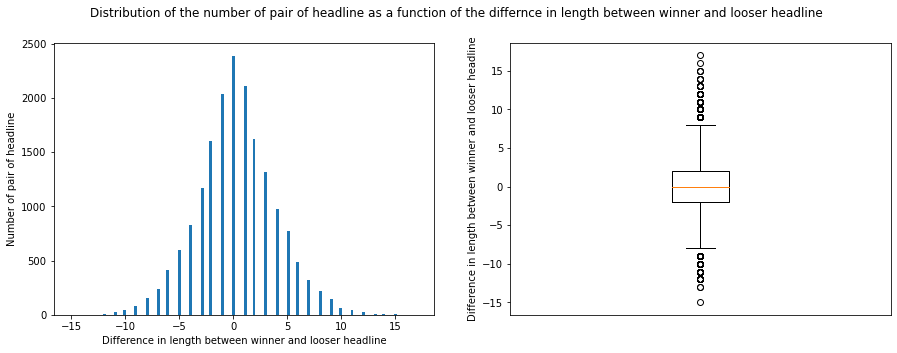

In [42]:
### Independent samples t-test
ind_t_test = ttest_ind(
    comparaison_final["numwords1"], comparaison_final["numwords2"], equal_var=True
)

### Paired t-test
paired_t_test = ttest_rel(
    comparaison_final["numwords1"], comparaison_final["numwords2"]
)

### Diff in legth between winner and looser headdline
diff = comparaison_final["numwords1"] - comparaison_final["numwords2"]
mean_diff = (diff).mean()
std_diff = (diff).std()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(
    "Distribution of the number of pair of headline as a function of the differnce in length between winner and looser headline "
)
ax1.hist(diff.values, bins=120)


ax1.set(
    xlabel="Difference in length between winner and looser headline",
    ylabel="Number of pair of headline",
)
ax2.boxplot(diff.values)
ax2 = ax2.set(
    xticks=[], ylabel="Difference in length between winner and looser headline"
)


print(
    "Independent t-test results =>  Statistics : %0.2f , pvalue: %1.2E"
    % (ind_t_test[0], ind_t_test[1])
)
print(
    "Paired t-test results =>  Statistics : %0.2f , pvalue: %1.2E"
    % (paired_t_test[0], paired_t_test[1])
)
print(
    "The mean difference is equal to %0.2f words, and the standard deviation is equal to %0.2f"
    % (mean_diff, std_diff)
)

**3.2 Discuss:** Are longer headlines more successful? Justify.

Paired t-test : $ (p_{value} < 0.05)  \Rightarrow$ we can reject the null hypothesis of identical average headline length. 

Independent t-test : $ (p_{value} < 0.05)  \Rightarrow$ we can reject the null hypothesis of identical average headline length. 

From the conducted tests, we know that the winning and loosing headlines do not have the same average length.   Thus headline length imports.

Since the mean difference in length between winner and losser headline is equal to 0.28 words, thus positive, we can conclude that longer headlines are more successful

**3.3** The [t-statistic](https://en.wikipedia.org/wiki/T-statistic) is the ratio of the departure of the estimated value of a parameter from its hypothesized value to its standard error. In a t-test, the higher the t-statistic, the more confidently we can reject the null hypothesis. Use `numpy.random` to create four samples, each of size 30:
- $X \sim Uniform(0,1)$
- $Y \sim Uniform(0,1)$
- $Z = X/2 + Y/2 + 0.1$
- $K = Y + 0.1$
    

In [43]:
x = np.random.uniform(low=0, high=1, size=30)
y = np.random.uniform(low=0, high=1, size=30)
z = x / 2 + y / 2 + 0.1
k = y + 0.1

**3.4 Discuss:** What are the expected values and the variance of $X$, $Y$, $Z$, and $K$? (You don't need to justify them!)

$E[X] = \frac{1}{2} $ 

$E[Y]= \frac{1}{2} $

$E[Z]= E[\frac{X}{2}+ \frac{Y}{2} + 0.1] = \frac{1}{2}E[X] + \frac{1}{2}E[Y] + 0.1 = 0.6$

$E[K]= E[Y + 0.1]= E[Y] + 0.1 = 0.6$

$Var[X] = E[(X)^2] - E[X]^2 = \frac{1}{3} - \frac{1}{4} = \frac{1}{12} $ 

$Var[Y] = \frac{1}{12} $

$Var[Z] = Var[\frac{X}{2}+ \frac{Y}{2} + 0.1] = Var[\frac{X}{2}] + Var[\frac{Y}{2}]= \frac{1}{4} (Var[X]+ Var[Y])= \frac{1}{24}   $

$Var[K] = Var[Y + 0.1]=  Var[Y ]=  \frac{1}{12} $ 


**3.5** Run the following simulation 10000 times, storing the $p$-values for the tests at each run:
- Sample new values  for $X$, $Y$, $Z$ and $K$ ($n=30$ each). 
- Run independent sample t-test (assuming equal variance) and paired t-test comparing $X$ and $Z$.
-  Run independent sample t-test (assuming equal variance) and paired t-test comparing $X$ and $K$.

In [44]:
n_iters = 10000
p_values_ind_x_z = []
p_values_paired_x_z = []
p_values_ind_x_k = []
p_values_paired_x_k = []
for i in range(n_iters):
    x = np.random.uniform(low=0, high=1, size=30)
    y = np.random.uniform(low=0, high=1, size=30)
    z = x / 2 + y / 2 + 0.1
    k = y + 0.1
    p_values_ind_x_z.append(ttest_ind(x, z, equal_var=True).pvalue)
    p_values_paired_x_z.append(ttest_rel(x, z).pvalue)
    p_values_ind_x_k.append(ttest_ind(x, k, equal_var=True).pvalue)
    p_values_paired_x_k.append(ttest_rel(x, k).pvalue)

**3.6** Recall that the power of a binary hypothesis test is the probability that the test correctly rejects the null hypothesis when the alternative hypothesis is true. Using the p-values and assuming that we reject the null hypothesis if $p < 0.05$, calculate the statistical power of:
- The independent sample t-test comparing $X$ and $Z$.
- The paired t-test comparing $X$ and $Z$.
- The independent sample t-test comparing $X$ and $K$.
- The paired t-test comparing $X$ and $K$.

In [45]:
stat_power_ind_x_z = len([x for x in p_values_ind_x_z if x < 0.05]) / n_iters
stat_power_paired_x_z = len([x for x in p_values_paired_x_z if x < 0.05]) / n_iters

stat_power_ind_x_k = len([x for x in p_values_ind_x_k if x < 0.05]) / n_iters
stat_power_paired_x_k = len([x for x in p_values_paired_x_k if x < 0.05]) / n_iters

print("The independent sample t-test comparing X and Z : %0.2f" % stat_power_ind_x_z)
print("The paired t-test comparing X and Z : %0.2f" % stat_power_paired_x_z)
print("The independent sample t-test comparing X and K : %0.2f" % stat_power_ind_x_k)
print("The paired t-test comparing X and K : %0.2f" % stat_power_paired_x_k)

The independent sample t-test comparing X and Z : 0.23
The paired t-test comparing X and Z : 0.74
The independent sample t-test comparing X and K : 0.25
The paired t-test comparing X and K : 0.25


**3.7 Discuss:** When are paired t-tests helpful? Justify.

Paired t-test are useful when comparing variables from matched pairs, i.e., there exist a (temporal, logical, etc. ) relationship between the pairs of random variables.

We can see that paired t-test are statistically stronger when applied on Z and X, which are related random variables, with $ P( $ reject $H_0 | H_1 $is true $) = 0.74 $ compared to when applied on X and K which are not related at all, with $ P( $ reject $H_0 | H_1 $is true $) = 0.26 $. 

In this particular case paired t-test are statsitically as strong as independent sample t-test.

**3.8** With a bootstrapping approach (implemented by yourself, you should not use existing bootstrapping functions), estimate the average difference and 95% confidence intervals for:
- the mean ratio between the number of words in the winner headline and the loser headline (i.e., the number of words in the winner headline divided by the number of words in the loser headlines).
- the difference in usage of positive words between winner and loser headlines.
- the difference in usage of negative words between winner and loser headlines.
- The difference in usage of each type of pronoun between winner and loser headlines.


In [78]:
def find_confidence_interval_in_list(means_list):
    return (np.quantile(means_list, 0.025), np.quantile(means_list, 0.975))


def batch_iter(series, batch_size, num_batches):
    data_size = len(series)
    shuffle_indices = np.random.permutation(np.arange(data_size))
    shuffled_series = series[series.index.values[shuffle_indices]]
    for batch_num in range(num_batches):
        strt = np.random.randint(data_size - batch_size)
        start_index = min(shuffle_indices[strt], shuffle_indices[strt] - batch_size)
        end_index = start_index + batch_size
        if start_index != end_index:
            yield shuffled_series[start_index:end_index].values


def calculate_means(batches):
    batches = filter(lambda x: len(x) != 0, batches)
    means_array = []
    for batch in batches:
        means_array.append(np.mean(batch))
    return means_array


def confidence_interval(serie, batch_size=7500, num_batches=10000):
    batches = list(batch_iter(serie, batch_size, num_batches))
    means = calculate_means(batches)
    return find_confidence_interval_in_list(means)

In [86]:
# 1
ratio_nb_words =  comparaison_final["numwords1"] / comparaison_final["numwords2"]
ci_mean_ratio = confidence_interval(ratio_nb_words)

avg_mean_ratio = ratio_nb_words.mean()
std_mean_ratio = ratio_nb_words.std()

print("ci_mean_ratio [%1.4f, %1.4f]" % ci_mean_ratio)
print("avg_mean_ratio %1.4f, std_mean_ratio %1.4f " % (avg_mean_ratio, std_mean_ratio))
print()

# 2
diff_pos_words = comparaison_final["positive1"] - comparaison_final["positive2"]
ci_pos_words = confidence_interval(diff_pos_words)
print("ci_pos_words [%1.4f, %1.4f]" % ci_pos_words)
avg_diff_pos_words = (diff_pos_words).mean()
std_diff_pos_words = (diff_pos_words).std()
print("avg_diff_pos_words %1.4f, std_diff_pos_words %1.4f "% (avg_diff_pos_words, std_diff_pos_words))
print()

# 3
diff_neg_words = comparaison_final["negative1"] - comparaison_final["negative2"]
ci_neg_words = confidence_interval(diff_neg_words)
avg_diff_neg_words = (diff_neg_words).mean()
std_diff_neg_words = (diff_neg_words).std()
print("ci_neg_words [%1.4f, %1.4f]" % ci_neg_words)
print("avg_diff_neg_words %1.4f, std_diff_neg_words %1.4f"% (avg_diff_neg_words, std_diff_neg_words))
print(),


ci_prononouns = {}
avg_diff_pronouns = {}
var_diff_pronouns = {}
for key in feature_wordsets:
    diff_pronouns =  comparaison_final[key + "1"] - comparaison_final[key + "2"]
    ci_prononouns[key] = confidence_interval(diff_pronouns      )
    print("ci_"+ key +  "[%1.4f, %1.4f]" % ci_prononouns[key])
    avg_diff_pronouns[key] = (diff_pronouns).mean()
    var_diff_pronouns[key] = (diff_pronouns).var()
    print(
        "avg_diff_%s %1.4f, var_diff_%s %1.4f "
        % (key, avg_diff_pronouns[key], key, var_diff_pronouns[key])
    )
    print()
  

ci_mean_ratio [1.0586, 1.0669]
avg_mean_ratio 1.0621, std_mean_ratio 0.3174 

ci_pos_words [-0.0102, 0.0007]
avg_diff_pos_words -0.0073, std_diff_pos_words 0.6217 

ci_neg_words [0.0087, 0.0240]
avg_diff_neg_words 0.0164, std_diff_neg_words 0.5760

ci_first_person_singular[0.0119, 0.0197]
avg_diff_first_person_singular 0.0152, var_diff_first_person_singular 0.1565 

ci_first_person_plural[-0.0164, -0.0071]
avg_diff_first_person_plural -0.0111, var_diff_first_person_plural 0.1440 

ci_second_person[-0.0057, 0.0108]
avg_diff_second_person 0.0044, var_diff_second_person 0.2694 

ci_third_person_singular[0.0313, 0.0432]
avg_diff_third_person_singular 0.0379, var_diff_third_person_singular 0.2860 

ci_third_person_plural[-0.0009, 0.0067]
avg_diff_third_person_plural 0.0030, var_diff_third_person_plural 0.1696 



3.9 **Discuss:** According to the results obtained in **T3.8**, what headlines grab people's attention the most? Justify your answer.

# <font color='red'>Todo</font> 

According to the previous results we can pinpoit some key elements that makes headline grab people's attention :

- Winner headlines are in average 6% longuer than the looser ones, thus there is a corrolation between the length and the success of the headlines.
- Negativity of the headlines seems to be determinant, since winner headlines, on average, contains less often positive words and more often negative ones 
- Headlines mentioning singular people are the most attractive ones : people tends to be more engaged by headlines dealing with individuals than groups 

## Task 4: Temporal validity and heterogeneity of the effect.

Last, we investigate how the effects studied in **T3** change with time and how they might be heterogeneous across different types of news.

4.1 Create a plot where you depict the monthly average number of words in winner and loser headlines. Consider only headlines created after April 2013 (the month of April inclusive). Include also bootstrapped 95% confidence intervals; here, you can use a third-party implementation if you want. Finally, recall that we created a column `date_created` which captures the creation of the winner headline; you can consider this date to correspond to the date of the creation of the A/B test.

4.2 Produce similar plots to each pronoun category, as well as for positive and negative sentiment. Here, unlike in **T4.1**, depict the month averages pooled across winner and loser headlines (i.e., for each month, you calculate the average across both winners and loser headlines).
Create all these plots in a single figure with no more than 11 inches of width and 11 inches of height. Again, consider only headlines created after April 2013 (the month of April inclusive).

4.3 **Discuss:** Has the type of headline Upworthy used in their A/B tests changed with time? Are these changes likely to be producing more or less engaging headlines? Justify.

4.4 Divide your data into two periods, $t_1$, which goes from  April 2013 (inclusive) to March 2014 (inclusive), and $t_2$, which goes from April 2014 (inclusive) to the latest A/B test in the data. Create a dataframe for A/B tests in each period.

4.5 Let's examine if the effects observed remained the same throughout the study period. Use an appropriate methodology  of your choice to determine if the effects observed in **T3.8** (length, each category of pronouns, positive words, and negative words) were different in $t_1$ and $t_2$. Here, note that we are considering "at least one positive outcome" to be the manifestation of an underlying effect, thus significance level must be adjusted down when performing multiple hypothesis tests!

4.6 **Discuss:** Hypothesize two reasons that could have led to a change in the observed effects. According to the analysis done in **T4.5**, have the effects observed remained the same across the study period? 

4.7 The features we are studying may interact with each other. For instance, people may like first person singular pronouns in headlines containing positive words (you are amazing!), but dislike headlines with negative words and first person pronouns (you are awful!). To help answer this question, create:
- a dataframe containing all A/B tests where both winner and loser headlines include a positive word; and
- a dataframe containing all A/B tests where both winner and loser headlines include a negative word;

4.8 Using an appropriate methodology of your choice, determine if the effect of the use of first person singular pronouns in the headline is heterogeneous across headlines with positive words and negative words, i.e., is the effect significantly stronger for one of the dataframes created in **T4.7**? 

4.9 **Discuss:** Considering the analyses you did throughout Tasks 3 and 4, write a short text (no more than 250 words) giving advice to Upworthy employees on how they should try to write engaging headlines. 
You can reference images present in the notebook by indicating a task (e.g., image plotted in **T3.3**) or a cell number. Note that you do not need to conduct any additional analysis to write this text. 


4.1 Create a plot where you depict the monthly average number of words in winner and loser headlines. Consider only headlines created after April 2013 (the month of April inclusive). Include also bootstrapped 95% confidence intervals; here, you can use a third-party implementation if you want. Finally, recall that we created a column `date_created` which captures the creation of the winner headline; you can consider this date to correspond to the date of the creation of the A/B test.

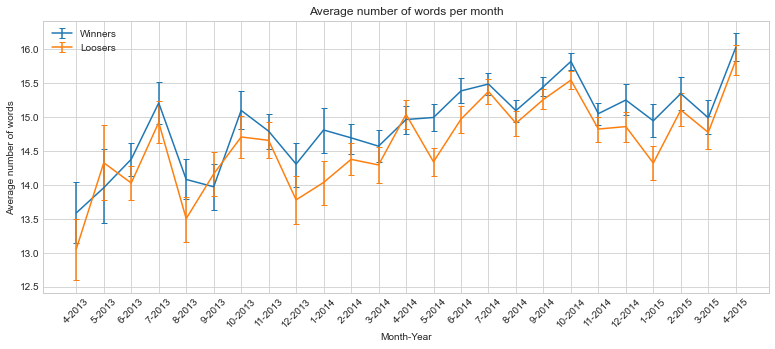

In [88]:
comparaison_final["date_created"] = comparaison_final["date_created"].astype(
    "datetime64[ns]"
)
after_april2013 = comparaison_final[comparaison_final["date_created"] >= "2013-04-01"]
comparaison_final_month = after_april2013.groupby(
    [after_april2013["date_created"].dt.month, after_april2013["date_created"].dt.year]
)


def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5), np.nanpercentile(means, 97.5)]


stats_by_month1 = comparaison_final_month.apply(
    lambda x: pd.Series(
        {
            "average_numwords1": x["numwords1"].mean(),
            "lower_err_numwords1": bootstrap_CI(x["numwords1"], 1000)[0],
            "upper_err_numwords2": bootstrap_CI(x["numwords1"], 1000)[1],
        }
    )
)

stats_by_month2 = comparaison_final_month.apply(
    lambda x: pd.Series(
        {
            "average_numwords2": x["numwords2"].mean(),
            "lower_err_numwords2": bootstrap_CI(x["numwords2"], 1000)[0],
            "upper_err_numwords2": bootstrap_CI(x["numwords2"], 1000)[1],
        }
    )
)

stats_by_month1 = stats_by_month1.sort_index(level=[1, 0])
stats_by_month2 = stats_by_month2.sort_index(level=[1, 0])

stats_by_month1.index = stats_by_month1.index.map(lambda x: str(x[0]) + "-" + str(x[1]))
stats_by_month2.index = stats_by_month2.index.map(lambda x: str(x[0]) + "-" + str(x[1]))

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(13, 5))
ax.errorbar(
    stats_by_month1.index,
    stats_by_month1.average_numwords1,
    yerr=[
        -stats_by_month1.lower_err_numwords1 + stats_by_month1.average_numwords1,
        -stats_by_month1.average_numwords1 + stats_by_month1.upper_err_numwords2,
    ],
    capsize=3,
)
ax.errorbar(
    stats_by_month2.index,
    stats_by_month2.average_numwords2,
    yerr=[
        -stats_by_month2.lower_err_numwords2 + stats_by_month2.average_numwords2,
        -stats_by_month2.average_numwords2 + stats_by_month2.upper_err_numwords2,
    ],
    capsize=3,
)

ax.set_xticks(stats_by_month1.index)
ax.set_xticklabels(stats_by_month1.index, rotation=45)
ax.set_xlabel("Month-Year")
ax.set_ylabel("Average number of words")
ax.set_title("Average number of words per month")
ax.legend(["Winners", "Loosers"])
plt.show()

4.2 Produce similar plots to each pronoun category, as well as for positive and negative sentiment. Here, unlike in **T4.1**, depict the month averages pooled across winner and loser headlines (i.e., for each month, you calculate the average across both winners and loser headlines).
Create all these plots in a single figure with no more than 11 inches of width and 11 inches of height. Again, consider only headlines created after April 2013 (the month of April inclusive).

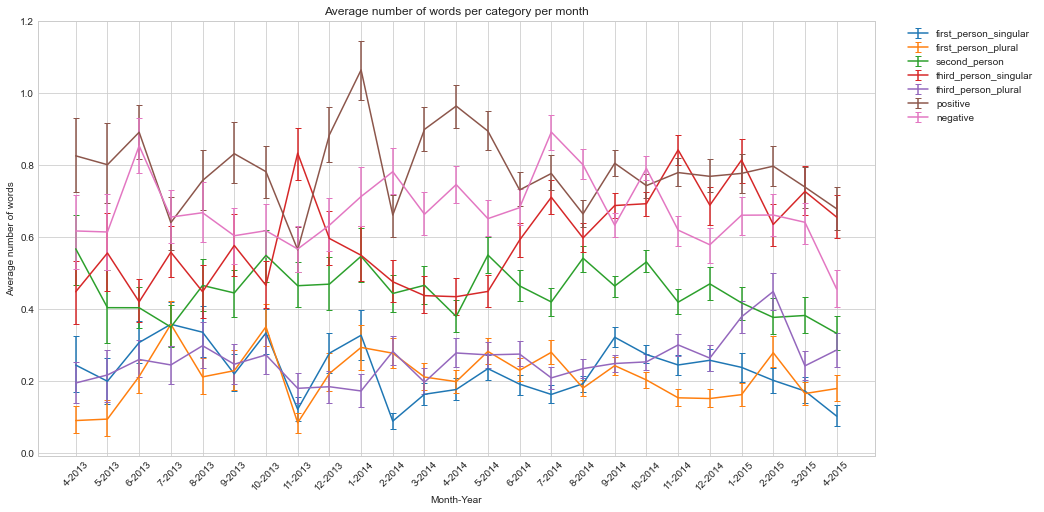

In [89]:
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))  # check if less than 11x11 inches

for key in feature_wordsets:
    comparaison_final[key] = comparaison_final[key + "1"] + comparaison_final[key + "2"]
    after_april2013 = comparaison_final[
        comparaison_final["date_created"] >= "2013-04-01"
    ]
    comparaison_final_month = after_april2013.groupby(
        [
            after_april2013["date_created"].dt.month,
            after_april2013["date_created"].dt.year,
        ]
    )

    stats_by_month = comparaison_final_month.apply(
        lambda x: pd.Series(
            {
                "average_" + key: x[key].mean(),
                "lower_err_" + key: bootstrap_CI(x[key], 1000)[0],
                "upper_err_" + key: bootstrap_CI(x[key], 1000)[1],
            }
        )
    )

    stats_by_month = stats_by_month.sort_index(level=[1, 0])
    stats_by_month.index = stats_by_month.index.map(
        lambda x: str(x[0]) + "-" + str(x[1])
    )

    ax.errorbar(
        stats_by_month.index,
        stats_by_month["average_" + key],
        yerr=[
            -stats_by_month["lower_err_" + key] + stats_by_month["average_" + key],
            -stats_by_month["average_" + key] + stats_by_month["upper_err_" + key],
        ],
        capsize=3,
    )

    # comparaison_final.drop(key, axis=1, inplace=True)

comparaison_final["positive"] = (
    comparaison_final["positive1"] + comparaison_final["positive2"]
)
comparaison_final["negative"] = (
    comparaison_final["negative1"] + comparaison_final["negative2"]
)
after_april2013 = comparaison_final[comparaison_final["date_created"] >= "2013-04-01"]
comparaison_final_month = after_april2013.groupby(
    [after_april2013["date_created"].dt.month, after_april2013["date_created"].dt.year]
)

stats_pos = comparaison_final_month.apply(
    lambda x: pd.Series(
        {
            "average_positive": x["positive"].mean(),
            "lower_err_positive": bootstrap_CI(x["positive"], 1000)[0],
            "upper_err_positive": bootstrap_CI(x["positive"], 1000)[1],
        }
    )
)
stats_neg = comparaison_final_month.apply(
    lambda x: pd.Series(
        {
            "average_negative": x["negative"].mean(),
            "lower_err_negative": bootstrap_CI(x["negative"], 1000)[0],
            "upper_err_negative": bootstrap_CI(x["negative"], 1000)[1],
        }
    )
)

stats_pos = stats_pos.sort_index(level=[1, 0])
stats_neg = stats_neg.sort_index(level=[1, 0])

stats_pos.index = stats_pos.index.map(lambda x: str(x[0]) + "-" + str(x[1]))
stats_neg.index = stats_neg.index.map(lambda x: str(x[0]) + "-" + str(x[1]))

ax.errorbar(
    stats_pos.index,
    stats_pos.average_positive,
    yerr=[
        -stats_pos.lower_err_positive + stats_pos.average_positive,
        -stats_pos.average_positive + stats_pos.upper_err_positive,
    ],
    capsize=3,
)
ax.errorbar(
    stats_neg.index,
    stats_neg.average_negative,
    yerr=[
        -stats_neg.lower_err_negative + stats_neg.average_negative,
        -stats_neg.average_negative + stats_neg.upper_err_negative,
    ],
    capsize=3,
)

# comparaison_final.drop(['positive', 'negative'], axis=1, inplace=True)

ax.set_xticks(stats_by_month1.index)
ax.set_xticklabels(stats_by_month1.index, rotation=45)
ax.set_xlabel("Month-Year")
ax.set_ylabel("Average number of words")
ax.legend(
    list(feature_wordsets) + ["positive", "negative"],
    loc="upper right",
    bbox_to_anchor=(1.2, 1),
)
ax.set_title("Average number of words per category per month")
plt.show()

4.3 **Discuss:** Has the type of headline Upworthy used in their A/B tests changed with time? Are these changes likely to be producing more or less engaging headlines? Justify.

We note that the average number of words has increased over time in both winner and looser headlines.
This is likely to produce more engaging headlines, as the average number of words in winner headlines is higher than the average number of words in loser headlines.

We also note that the average number of negative and positive words has decreased at the end of the study period in both winner and looser headlines.

The use of second person pronouns has also decreased in both winner and looser headlines whereas the use of third person pronouns has significantly increased.

Headlines tend thus to be more neutral and less personal over time. 

4.4 Divide your data into two periods, $t_1$, which goes from  April 2013 (inclusive) to March 2014 (inclusive), and $t_2$, which goes from April 2014 (inclusive) to the latest A/B test in the data. Create a dataframe for A/B tests in each period.

In [90]:
comparaison_final["length"] = (
    comparaison_final["numwords1"] + comparaison_final["numwords2"]
) / 2
t1 = comparaison_final[
    (comparaison_final["date_created"] >= "2013-04-01")
    & (comparaison_final["date_created"] < "2014-04-01")
]
t2 = comparaison_final[comparaison_final["date_created"] >= "2014-04-01"]

In [91]:
min = t1["date_created"].min()
max = t1["date_created"].max()
print((str(min), str(max)))

('2013-04-01 05:46:19', '2014-03-31 22:14:48.452000')


In [92]:
min = t2["date_created"].min()
max = t2["date_created"].max()
print((str(min), str(max)))

('2014-04-01 00:17:45.752000', '2015-04-29 20:28:36.176000')


4.5 Let's examine if the effects observed remained the same throughout the study period. Use an appropriate methodology  of your choice to determine if the effects observed in **T3.8** (length, each category of pronouns, positive words, and negative words) were different in $t_1$ and $t_2$. Here, note that we are considering "at least one positive outcome" to be the manifestation of an underlying effect, thus significance level must be adjusted down when performing multiple hypothesis tests!

In [105]:
ttest = ttest_ind(t1["length"], t2["length"])
print("length: t-test= {0:.3f}, p-value= {1:.3f}".format(ttest[0], ttest[1]))
print('Average length diff ' + str(t2["length"].mean()- t1["length"].mean()))
for key in feature_wordsets:
    ttest = ttest_ind(t1[key], t2[key])
    print("{}: t-test={}, p-value={}".format(key, ttest[0], ttest[1]))
    # comparaison_final.drop(key, axis=1, inplace=True)

ttest = ttest_ind(t1["positive"], t2["positive"])
print("positive: t-test= {0:.3f}, p-value= {1:.3f}".format(ttest[0], ttest[1]))
ttest = ttest_ind(t1["negative"], t2["negative"])
print("negative: t-test= {0:.3f}, p-value= {1:.3f}".format(ttest[0], ttest[1]))

# comparaison_final.drop(['length', 'positive', 'negative'], axis=1, inplace=True)

length: t-test= -19.516, p-value= 0.000
Average length diff 0.8162440001668809
first_person_singular: t-test=0.9272699628041503, p-value=0.35379917744574907
first_person_plural: t-test=2.5467797801882615, p-value=0.010880690724776652
second_person: t-test=0.21394194904947392, p-value=0.8305948200764911
third_person_singular: t-test=-10.475541540786297, p-value=1.3322526102125215e-25
third_person_plural: t-test=-4.57851766726774, p-value=4.715074809613784e-06
positive: t-test= 1.500, p-value= 0.134
negative: t-test= -1.660, p-value= 0.097


4.6 **Discuss:** Hypothesize two reasons that could have led to a change in the observed effects. According to the analysis done in **T4.5**, have the effects observed remained the same across the study period? 

# <font color='red'>Todo</font> <br>

<font color='red'>
  I did not understand the question but what I can infer from the data is : <br>
- The average length did drastically change : t2 length > t1 length (on average nearly 0.8 words more)<br>
- Third_person_singular differs a lot in the two groups : more in t1<br>
- Third hird_person_plural<br>
</font> 

4.7 The features we are studying may interact with each other. For instance, people may like first person singular pronouns in headlines containing positive words (you are amazing!), but dislike headlines with negative words and first person pronouns (you are awful!). To help answer this question, create:
- a dataframe containing all A/B tests where both winner and loser headlines include a positive word; and
- a dataframe containing all A/B tests where both winner and loser headlines include a negative word;

In [29]:
winner_looser_pos = comparaison_final[
    (comparaison_final["positive1"] > 0) & (comparaison_final["positive2"] > 0)
]
winner_looser_neg = comparaison_final[
    (comparaison_final["negative1"] > 0) & (comparaison_final["negative2"] > 0)
]
print(
    "There are {} A/B tests where both headlines include at least a positive word".format(
        len(winner_looser_pos)
    )
)
print(
    "There are {} A/B tests where both headlines include at least a negative word".format(
        len(winner_looser_neg)
    )
)

There are 3460 A/B tests where both headlines include at least a positive word
There are 3192 A/B tests where both headlines include at least a negative word


4.8 Using an appropriate methodology of your choice, determine if the effect of the use of first person singular pronouns in the headline is heterogeneous across headlines with positive words and negative words, i.e., is the effect significantly stronger for one of the dataframes created in **T4.7**? 

In [30]:
ttest = ttest_ind(
    winner_looser_pos["first_person_singular"],
    winner_looser_neg["first_person_singular"],
)
print(
    "first_person_singular: t-test= {0:.3f}, p-value= {1:.3f}".format(
        ttest[0], ttest[1]
    )
)

first_person_singular: t-test= 0.429, p-value= 0.668


4.9 **Discuss:** Considering the analyses you did throughout Tasks 3 and 4, write a short text (no more than 250 words) giving advice to Upworthy employees on how they should try to write engaging headlines. 
You can reference images present in the notebook by indicating a task (e.g., image plotted in **T3.3**) or a cell number. Note that you do not need to conduct any additional analysis to write this text. 

# <font color='red'>Todo</font> 